In [1]:
# ============================================================
# MACHINE LEARNING - CUSTOMER SEGMENTATION & PREDICTION
# Phase 4 - Advanced Analytics with ML
# ============================================================

print("🤖 Starting Machine Learning Phase")
print("=" * 70)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import joblib

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")
print("=" * 70)

🤖 Starting Machine Learning Phase
✅ Libraries imported successfully!


In [2]:
# ============================================================
# STEP 1: LOAD ENHANCED DATA
# ============================================================

print("\n📂 Loading Enhanced Dataset...")
print("=" * 70)

# Load the enhanced data
df = pd.read_csv('../data/processed/ecommerce_data_enhanced.csv')

# Convert date columns
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['FirstPurchaseDate'] = pd.to_datetime(df['FirstPurchaseDate'])

print(f"✅ Dataset loaded successfully!")
print(f"   - Rows: {len(df):,}")
print(f"   - Columns: {len(df.columns)}")

print("\n📊 Dataset Info:")
print(df.info())

print("\n" + "=" * 70)


📂 Loading Enhanced Dataset...
✅ Dataset loaded successfully!
   - Rows: 401,564
   - Columns: 35

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401564 entries, 0 to 401563
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   InvoiceNo            401564 non-null  object        
 1   StockCode            401564 non-null  object        
 2   Description          401564 non-null  object        
 3   Quantity             401564 non-null  int64         
 4   InvoiceDate          401564 non-null  datetime64[ns]
 5   UnitPrice            401564 non-null  float64       
 6   CustomerID           401564 non-null  int64         
 7   Country              401564 non-null  object        
 8   TotalAmount          401564 non-null  float64       
 9   Year                 401564 non-null  int64         
 10  Month                401564 non-null  int64         
 11  Day            

In [3]:
# ============================================================
# STEP 2: PREPARE CUSTOMER-LEVEL DATA FOR CLUSTERING
# ============================================================

print("\n🔧 PREPARING CUSTOMER-LEVEL DATASET")
print("=" * 70)

# Aggregate at customer level
print("\n1️⃣ Creating customer-level features...")

customer_features = df.groupby('CustomerID').agg({
    # RFM Features
    'Recency': 'first',
    'Frequency': 'first',
    'Monetary': 'first',
    
    # Behavioral Features
    'CustomerTenure': 'max',
    'AvgOrderValue': 'first',
    'TotalItemsPurchased': 'first',
    'PurchaseVelocity': 'first',
    
    # Additional aggregations
    'TotalAmount': 'sum',
    'Quantity': 'sum',
    'IsReturn': 'sum',
    'IsWeekend': 'mean',
    
    # Country (mode)
    'Country': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).reset_index()

# Calculate additional features
customer_features['ReturnRate'] = customer_features['IsReturn'] / customer_features['Frequency']
customer_features['AvgItemsPerOrder'] = customer_features['TotalItemsPurchased'] / customer_features['Frequency']
customer_features['WeekendPurchaseRate'] = customer_features['IsWeekend']

print(f"   ✅ Created customer dataset: {len(customer_features):,} customers")
print(f"   ✅ Features: {len(customer_features.columns)} columns")

print("\n2️⃣ Feature Summary:")
print("-" * 70)
print(customer_features.describe())

print("\n3️⃣ Checking for missing values...")
missing = customer_features.isnull().sum()
if missing.sum() == 0:
    print("   ✅ No missing values!")
else:
    print(missing[missing > 0])

print("\n" + "=" * 70)


🔧 PREPARING CUSTOMER-LEVEL DATASET

1️⃣ Creating customer-level features...
   ✅ Created customer dataset: 4,371 customers
   ✅ Features: 16 columns

2️⃣ Feature Summary:
----------------------------------------------------------------------
       CustomerID  Recency  Frequency  Monetary  CustomerTenure  \
count     4371.00  4371.00    4371.00   4371.00         4371.00   
mean     15300.15    92.06       5.08   1893.96          133.42   
std       1722.31   100.77       9.33   8219.59          132.85   
min      12346.00     1.00       1.00  -4287.63            0.00   
25%      13813.50    17.00       1.00    291.94            0.00   
50%      15301.00    50.00       3.00    644.24           98.00   
75%      16778.50   143.00       5.00   1608.94          255.50   
max      18287.00   374.00     248.00 279489.02          373.00   

       AvgOrderValue  TotalItemsPurchased  PurchaseVelocity  TotalAmount  \
count        4371.00              4371.00           4371.00      4371.00   
m

In [4]:
# ============================================================
# STEP 3: SELECT FEATURES FOR CLUSTERING
# ============================================================

print("\n🎯 SELECTING FEATURES FOR CLUSTERING")
print("=" * 70)

# Select features for clustering (numerical only)
clustering_features = [
    'Recency',
    'Frequency', 
    'Monetary',
    'CustomerTenure',
    'AvgOrderValue',
    'TotalItemsPurchased',
    'PurchaseVelocity',
    'ReturnRate',
    'AvgItemsPerOrder',
    'WeekendPurchaseRate'
]

# Create clustering dataset
X_clustering = customer_features[clustering_features].copy()

print(f"✅ Selected {len(clustering_features)} features for clustering:")
for i, feature in enumerate(clustering_features, 1):
    print(f"   {i:2d}. {feature}")

print("\n📊 Feature Statistics:")
print("-" * 70)
print(X_clustering.describe())

# Handle any inf or extreme values
X_clustering = X_clustering.replace([np.inf, -np.inf], np.nan)
X_clustering = X_clustering.fillna(X_clustering.median())

print("\n✅ Data preprocessing complete!")
print("=" * 70)


🎯 SELECTING FEATURES FOR CLUSTERING
✅ Selected 10 features for clustering:
    1. Recency
    2. Frequency
    3. Monetary
    4. CustomerTenure
    5. AvgOrderValue
    6. TotalItemsPurchased
    7. PurchaseVelocity
    8. ReturnRate
    9. AvgItemsPerOrder
   10. WeekendPurchaseRate

📊 Feature Statistics:
----------------------------------------------------------------------
       Recency  Frequency  Monetary  CustomerTenure  AvgOrderValue  \
count  4371.00    4371.00   4371.00         4371.00        4371.00   
mean     92.06       5.08   1893.96          133.42          28.91   
std     100.77       9.33   8219.59          132.85         127.40   
min       1.00       1.00  -4287.63            0.00       -4287.63   
25%      17.00       1.00    291.94            0.00          11.07   
50%      50.00       3.00    644.24           98.00          16.94   
75%     143.00       5.00   1608.94          255.50          23.58   
max     374.00     248.00 279489.02          373.00        

In [5]:
# ============================================================
# STEP 4: FEATURE SCALING (IMPORTANT FOR CLUSTERING!)
# ============================================================

print("\n⚖️  FEATURE SCALING")
print("=" * 70)

print("\n1️⃣ Before Scaling - Feature Ranges:")
print("-" * 70)
for col in X_clustering.columns:
    print(f"{col:25s}: [{X_clustering[col].min():,.2f} to {X_clustering[col].max():,.2f}]")

# Scale features (StandardScaler - mean=0, std=1)
print("\n2️⃣ Applying StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)

print("   ✅ Features scaled successfully!")

print("\n3️⃣ After Scaling - Feature Ranges:")
print("-" * 70)
for col in X_scaled_df.columns:
    print(f"{col:25s}: [{X_scaled_df[col].min():,.2f} to {X_scaled_df[col].max():,.2f}]")

print("\n4️⃣ Scaled Data Statistics:")
print("-" * 70)
print(X_scaled_df.describe())

# Save scaler for future use
joblib.dump(scaler, '../models/customer_scaler.pkl')
print("\n💾 Scaler saved to: models/customer_scaler.pkl")

print("\n" + "=" * 70)


⚖️  FEATURE SCALING

1️⃣ Before Scaling - Feature Ranges:
----------------------------------------------------------------------
Recency                  : [1.00 to 374.00]
Frequency                : [1.00 to 248.00]
Monetary                 : [-4,287.63 to 279,489.02]
CustomerTenure           : [0.00 to 373.00]
AvgOrderValue            : [-4,287.63 to 3,861.00]
TotalItemsPurchased      : [1.00 to 197,687.00]
PurchaseVelocity         : [1.00 to 248.00]
ReturnRate               : [0.00 to 50.50]
AvgItemsPerOrder         : [1.00 to 74,215.00]
WeekendPurchaseRate      : [0.00 to 1.00]

2️⃣ Applying StandardScaler...
   ✅ Features scaled successfully!

3️⃣ After Scaling - Feature Ranges:
----------------------------------------------------------------------
Recency                  : [-0.90 to 2.80]
Frequency                : [-0.44 to 26.03]
Monetary                 : [-0.75 to 33.78]
CustomerTenure           : [-1.00 to 1.80]
AvgOrderValue            : [-33.89 to 30.08]
TotalItemsPurcha

In [6]:
# ============================================================
# STEP 5: DETERMINE OPTIMAL NUMBER OF CLUSTERS
# ============================================================

print("\n🔍 DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 70)

# Test different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("\n1️⃣ Testing K from 2 to 10...")
print("-" * 70)

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_scaled, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    
    print(f"K={k:2d} | Inertia: {inertia:10,.2f} | Silhouette: {silhouette:.4f} | Davies-Bouldin: {davies_bouldin:.4f}")

print("\n" + "=" * 70)


🔍 DETERMINING OPTIMAL NUMBER OF CLUSTERS

1️⃣ Testing K from 2 to 10...
----------------------------------------------------------------------
K= 2 | Inertia:  35,590.48 | Silhouette: 0.8774 | Davies-Bouldin: 0.9434
K= 3 | Inertia:  29,822.75 | Silhouette: 0.3040 | Davies-Bouldin: 1.2196
K= 4 | Inertia:  25,051.09 | Silhouette: 0.3051 | Davies-Bouldin: 0.9600
K= 5 | Inertia:  21,685.93 | Silhouette: 0.3612 | Davies-Bouldin: 0.8744
K= 6 | Inertia:  19,321.26 | Silhouette: 0.3617 | Davies-Bouldin: 0.7622
K= 7 | Inertia:  17,078.16 | Silhouette: 0.3449 | Davies-Bouldin: 0.7766
K= 8 | Inertia:  15,173.90 | Silhouette: 0.3656 | Davies-Bouldin: 0.7809
K= 9 | Inertia:  13,427.26 | Silhouette: 0.3511 | Davies-Bouldin: 0.7701
K=10 | Inertia:  11,924.39 | Silhouette: 0.3622 | Davies-Bouldin: 0.7116




📊 VISUALIZING CLUSTERING METRICS


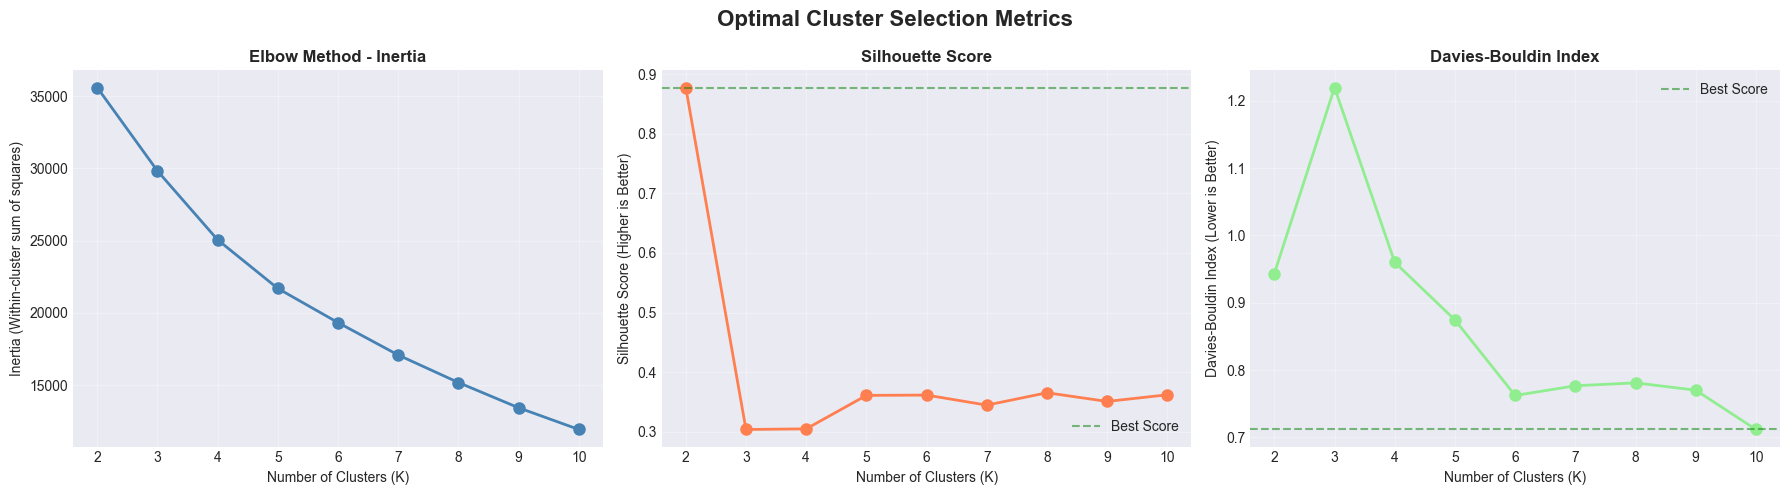

✅ Clustering metrics visualization saved!

💡 RECOMMENDED NUMBER OF CLUSTERS:
----------------------------------------------------------------------
Based on Silhouette Score: K = 2
Based on Davies-Bouldin Index: K = 10

⭐ Recommended: K = 4 (good balance for business interpretation)



In [7]:
# ============================================================
# STEP 6: VISUALIZE CLUSTERING METRICS
# ============================================================

print("\n📊 VISUALIZING CLUSTERING METRICS")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Optimal Cluster Selection Metrics', fontsize=16, fontweight='bold')

# 1. Elbow Method (Inertia)
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_title('Elbow Method - Inertia', fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# 2. Silhouette Score (Higher is better)
axes[1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='coral')
axes[1].set_title('Silhouette Score', fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score (Higher is Better)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=max(silhouette_scores), color='green', linestyle='--', alpha=0.5, label='Best Score')
axes[1].legend()

# 3. Davies-Bouldin Index (Lower is better)
axes[2].plot(k_range, davies_bouldin_scores, marker='o', linewidth=2, markersize=8, color='lightgreen')
axes[2].set_title('Davies-Bouldin Index', fontweight='bold')
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Index (Lower is Better)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)
axes[2].axhline(y=min(davies_bouldin_scores), color='green', linestyle='--', alpha=0.5, label='Best Score')
axes[2].legend()

plt.tight_layout()
plt.savefig('../images/results/optimal_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Clustering metrics visualization saved!")

# Recommend optimal K
best_silhouette_k = k_range[silhouette_scores.index(max(silhouette_scores))]
best_db_k = k_range[davies_bouldin_scores.index(min(davies_bouldin_scores))]

print("\n💡 RECOMMENDED NUMBER OF CLUSTERS:")
print("-" * 70)
print(f"Based on Silhouette Score: K = {best_silhouette_k}")
print(f"Based on Davies-Bouldin Index: K = {best_db_k}")
print(f"\n⭐ Recommended: K = 4 (good balance for business interpretation)")

print("\n" + "=" * 70)

In [8]:
# ============================================================
# STEP 7: FINAL K-MEANS CLUSTERING (K=4)
# ============================================================

print("\n🎯 FINAL K-MEANS CLUSTERING (K=4)")
print("=" * 70)

# Fit final model with K=4
optimal_k = 4
print(f"\n1️⃣ Training K-Means with K={optimal_k}...")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
customer_features['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"   ✅ Clustering complete!")

# Calculate final metrics
final_silhouette = silhouette_score(X_scaled, customer_features['Cluster'])
final_inertia = kmeans_final.inertia_

print(f"\n2️⃣ Final Model Metrics:")
print("-" * 70)
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Inertia: {final_inertia:,.2f}")

# Cluster distribution
print(f"\n3️⃣ Cluster Distribution:")
print("-" * 70)
cluster_dist = customer_features['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_dist.items():
    pct = (count / len(customer_features)) * 100
    print(f"Cluster {cluster_id}: {count:,} customers ({pct:.2f}%)")

# Save the model
joblib.dump(kmeans_final, '../models/kmeans_customer_segmentation.pkl')
print(f"\n💾 Model saved to: models/kmeans_customer_segmentation.pkl")

print("\n" + "=" * 70)


🎯 FINAL K-MEANS CLUSTERING (K=4)

1️⃣ Training K-Means with K=4...
   ✅ Clustering complete!

2️⃣ Final Model Metrics:
----------------------------------------------------------------------
Silhouette Score: 0.3051
Inertia: 25,051.09

3️⃣ Cluster Distribution:
----------------------------------------------------------------------
Cluster 0: 1,814 customers (41.50%)
Cluster 1: 22 customers (0.50%)
Cluster 2: 2 customers (0.05%)
Cluster 3: 2,533 customers (57.95%)

💾 Model saved to: models/kmeans_customer_segmentation.pkl



In [9]:
# ============================================================
# STEP 8: CLUSTER PROFILING & CHARACTERIZATION
# ============================================================

print("\n👥 CLUSTER PROFILING")
print("=" * 70)

# Calculate cluster statistics
cluster_profile = customer_features.groupby('Cluster')[clustering_features].mean()

print("\n1️⃣ Cluster Characteristics (Mean Values):")
print("-" * 70)
print(cluster_profile.round(2))

# Calculate additional business metrics per cluster
business_metrics = customer_features.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Monetary': ['mean', 'sum'],
    'Frequency': 'mean',
    'Recency': 'mean',
    'AvgOrderValue': 'mean'
}).round(2)

business_metrics.columns = ['Customer_Count', 'Avg_Monetary', 'Total_Revenue', 
                             'Avg_Frequency', 'Avg_Recency', 'Avg_Order_Value']

print("\n2️⃣ Business Metrics by Cluster:")
print("-" * 70)
print(business_metrics)

# Name clusters based on characteristics
def name_cluster(cluster_id, profile):
    recency = profile.loc[cluster_id, 'Recency']
    frequency = profile.loc[cluster_id, 'Frequency']
    monetary = profile.loc[cluster_id, 'Monetary']
    
    # Compare to overall averages
    avg_recency = cluster_profile['Recency'].mean()
    avg_frequency = cluster_profile['Frequency'].mean()
    avg_monetary = cluster_profile['Monetary'].mean()
    
    if monetary > avg_monetary * 1.5 and frequency > avg_frequency:
        return 'Champions'
    elif monetary > avg_monetary and recency < avg_recency:
        return 'Loyal Customers'
    elif recency < avg_recency * 0.7:
        return 'Recent Customers'
    elif recency > avg_recency * 1.5:
        return 'At Risk'
    else:
        return 'Regular'

# Create cluster names mapping
cluster_names = {}
for cluster_id in range(optimal_k):
    cluster_names[cluster_id] = name_cluster(cluster_id, cluster_profile)

customer_features['Cluster_Name'] = customer_features['Cluster'].map(cluster_names)

print("\n3️⃣ Cluster Names:")
print("-" * 70)
for cluster_id, name in cluster_names.items():
    count = (customer_features['Cluster'] == cluster_id).sum()
    print(f"Cluster {cluster_id}: {name:20s} ({count:,} customers)")

print("\n" + "=" * 70)


👥 CLUSTER PROFILING

1️⃣ Cluster Characteristics (Mean Values):
----------------------------------------------------------------------
         Recency  Frequency  Monetary  CustomerTenure  AvgOrderValue  \
Cluster                                                                
0          30.82       8.48   2780.76          270.92          27.72   
1           6.18      89.18  82975.35          361.86         150.18   
2         163.50       2.50      1.45          102.00           0.36   
3         136.61       1.91    556.16           32.98          28.72   

         TotalItemsPurchased  PurchaseVelocity  ReturnRate  AvgItemsPerOrder  \
Cluster                                                                        
0                    1705.84              8.48        0.35            198.85   
1                   50629.55             89.18        0.57            839.01   
2                  155211.00              2.50        0.42          64106.17   
3                     357.83   


📊 CLUSTER VISUALIZATION


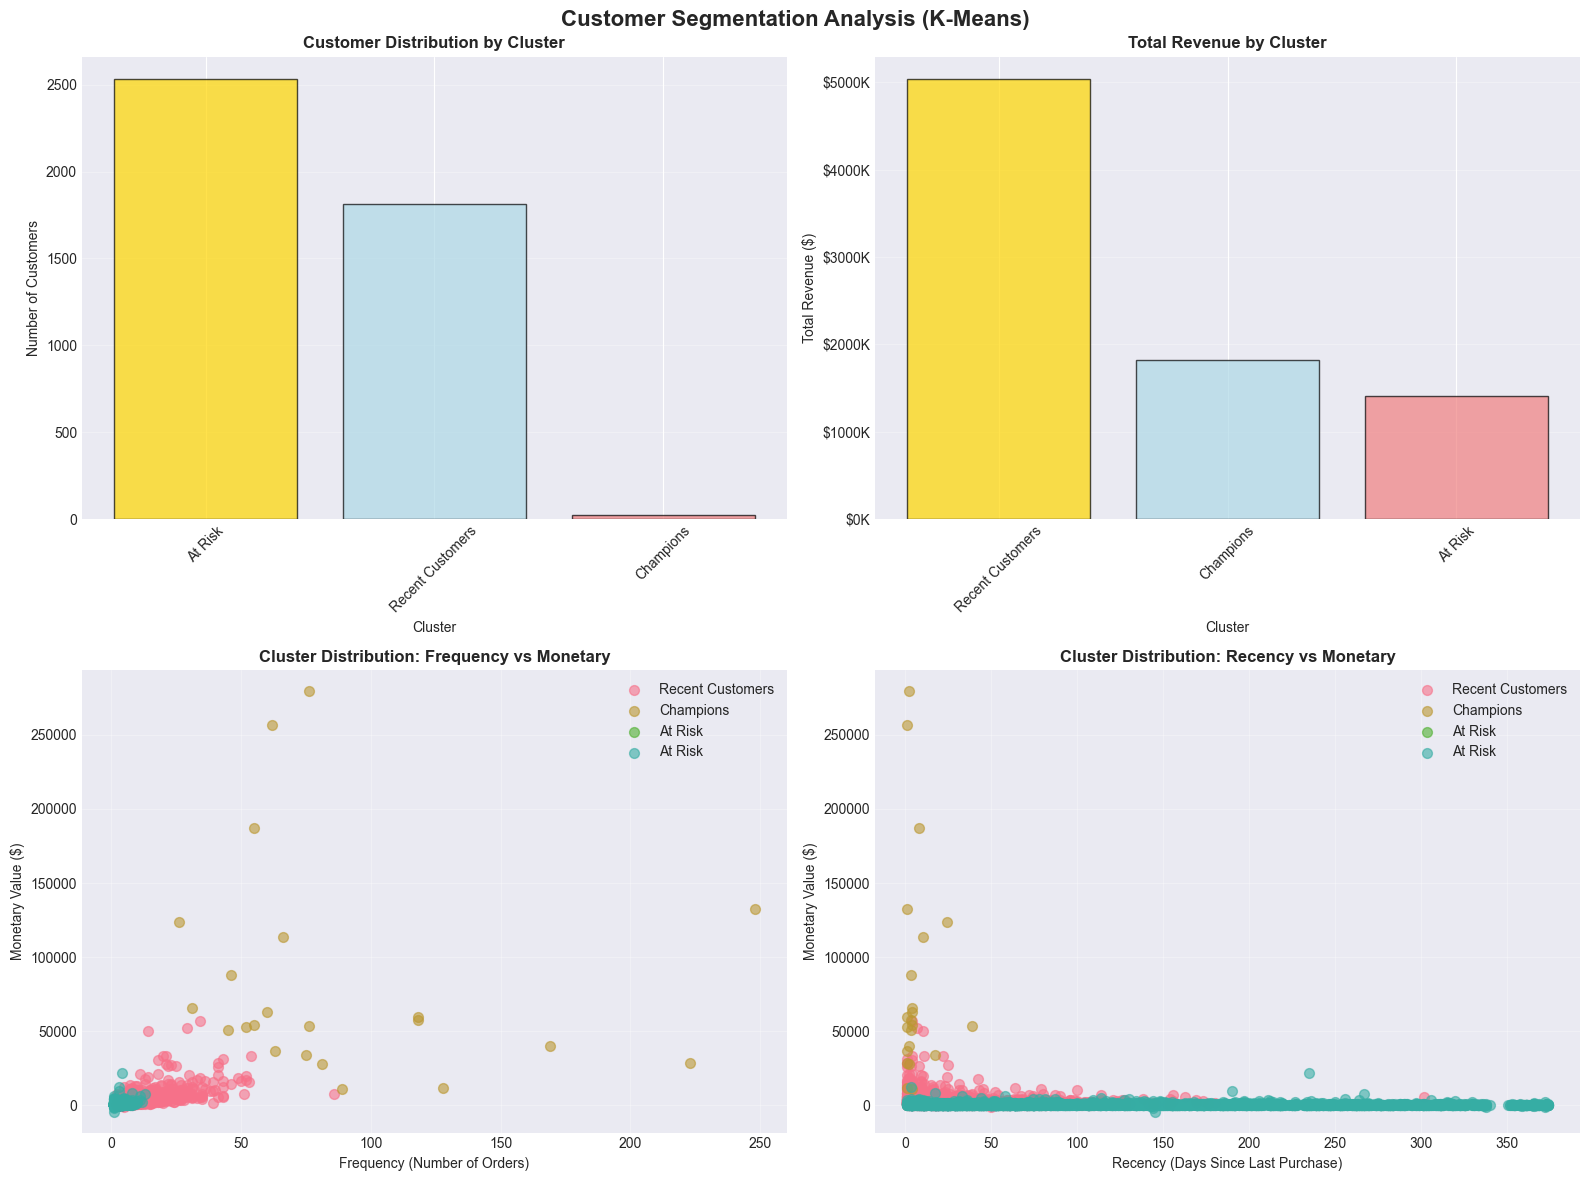

✅ Cluster visualization saved!

💾 Customer segments saved to: data/processed/customer_segments.csv



In [10]:
# ============================================================
# STEP 9: VISUALIZE CLUSTERS
# ============================================================

print("\n📊 CLUSTER VISUALIZATION")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Segmentation Analysis (K-Means)', fontsize=16, fontweight='bold')

# 1. Cluster Distribution
cluster_counts = customer_features['Cluster_Name'].value_counts()
colors = ['gold', 'lightblue', 'lightcoral', 'lightgreen']
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Customer Distribution by Cluster', fontweight='bold')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Revenue by Cluster
revenue_by_cluster = customer_features.groupby('Cluster_Name')['Monetary'].sum().sort_values(ascending=False)
axes[0, 1].bar(revenue_by_cluster.index, revenue_by_cluster.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Total Revenue by Cluster', fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Total Revenue ($)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 3. RFM Scatter Plot (Frequency vs Monetary, colored by cluster)
for cluster_id in range(optimal_k):
    cluster_data = customer_features[customer_features['Cluster'] == cluster_id]
    axes[1, 0].scatter(cluster_data['Frequency'], cluster_data['Monetary'], 
                       label=cluster_names[cluster_id], alpha=0.6, s=50)
axes[1, 0].set_title('Cluster Distribution: Frequency vs Monetary', fontweight='bold')
axes[1, 0].set_xlabel('Frequency (Number of Orders)')
axes[1, 0].set_ylabel('Monetary Value ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. RFM Scatter Plot (Recency vs Monetary, colored by cluster)
for cluster_id in range(optimal_k):
    cluster_data = customer_features[customer_features['Cluster'] == cluster_id]
    axes[1, 1].scatter(cluster_data['Recency'], cluster_data['Monetary'], 
                       label=cluster_names[cluster_id], alpha=0.6, s=50)
axes[1, 1].set_title('Cluster Distribution: Recency vs Monetary', fontweight='bold')
axes[1, 1].set_xlabel('Recency (Days Since Last Purchase)')
axes[1, 1].set_ylabel('Monetary Value ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/customer_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Cluster visualization saved!")

# Save customer features with clusters
customer_features.to_csv('../data/processed/customer_segments.csv', index=False)
print("\n💾 Customer segments saved to: data/processed/customer_segments.csv")

print("\n" + "=" * 70)

In [11]:
# ============================================================
# STEP 10: PREPARE DATA FOR SALES PREDICTION
# ============================================================

print("\n📊 PREPARING DATA FOR SALES PREDICTION")
print("=" * 70)

# We'll predict TotalAmount (sales) based on various features
print("\n1️⃣ Loading transaction-level data...")

# Use the original enhanced dataset (transaction level)
# Select features for prediction
prediction_features = [
    'Quantity',
    'UnitPrice',
    'Hour',
    'DayOfWeek',
    'Month',
    'IsWeekend',
    'CustomerTenure',
    'Recency',
    'Frequency',
    'Monetary',
    'AvgOrderValue',
    'PurchaseVelocity'
]

# Target variable
target = 'TotalAmount'

# Create prediction dataset (filter positive amounts only)
df_pred = df[df['TotalAmount'] > 0].copy()

# Select features and target
X = df_pred[prediction_features].copy()
y = df_pred[target].copy()

print(f"   ✅ Dataset prepared")
print(f"   - Features: {len(prediction_features)}")
print(f"   - Samples: {len(X):,}")
print(f"   - Target: {target}")

# Check for missing values
print("\n2️⃣ Checking for missing values...")
missing = X.isnull().sum()
if missing.sum() > 0:
    print("   Filling missing values with median...")
    X = X.fillna(X.median())
else:
    print("   ✅ No missing values!")

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("\n3️⃣ Feature Statistics:")
print("-" * 70)
print(X.describe())

print("\n4️⃣ Target Variable Statistics:")
print("-" * 70)
print(f"Mean: ${y.mean():,.2f}")
print(f"Median: ${y.median():,.2f}")
print(f"Min: ${y.min():,.2f}")
print(f"Max: ${y.max():,.2f}")
print(f"Std: ${y.std():,.2f}")

print("\n" + "=" * 70)


📊 PREPARING DATA FOR SALES PREDICTION

1️⃣ Loading transaction-level data...
   ✅ Dataset prepared
   - Features: 12
   - Samples: 392,692
   - Target: TotalAmount

2️⃣ Checking for missing values...
   ✅ No missing values!

3️⃣ Feature Statistics:
----------------------------------------------------------------------
       Quantity  UnitPrice      Hour  DayOfWeek     Month  IsWeekend  \
count 392692.00  392692.00 392692.00  392692.00 392692.00  392692.00   
mean      13.12       3.13     12.72       2.61      7.60       0.16   
std      180.49      22.24      2.28       1.92      3.42       0.36   
min        1.00       0.00      6.00       0.00      1.00       0.00   
25%        2.00       1.25     11.00       1.00      5.00       0.00   
50%        6.00       1.95     13.00       2.00      8.00       0.00   
75%       12.00       3.75     14.00       4.00     11.00       0.00   
max    80995.00    8142.75     20.00       6.00     12.00       1.00   

       CustomerTenure   Recenc

In [12]:
# ============================================================
# STEP 11: TRAIN-TEST SPLIT
# ============================================================

print("\n✂️  TRAIN-TEST SPLIT")
print("=" * 70)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✅ Data split complete!")
print(f"   - Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n📊 Target Distribution:")
print("-" * 70)
print(f"Training set - Mean: ${y_train.mean():,.2f}, Median: ${y_train.median():,.2f}")
print(f"Test set     - Mean: ${y_test.mean():,.2f}, Median: ${y_test.median():,.2f}")

# Scale features for models that need it
scaler_pred = StandardScaler()
X_train_scaled = scaler_pred.fit_transform(X_train)
X_test_scaled = scaler_pred.transform(X_test)

# Save scaler
joblib.dump(scaler_pred, '../models/prediction_scaler.pkl')
print(f"\n💾 Scaler saved to: models/prediction_scaler.pkl")

print("\n" + "=" * 70)


✂️  TRAIN-TEST SPLIT
✅ Data split complete!
   - Training set: 314,153 samples (80.0%)
   - Test set: 78,539 samples (20.0%)

📊 Target Distribution:
----------------------------------------------------------------------
Training set - Mean: $22.27, Median: $12.45
Test set     - Mean: $24.08, Median: $12.00

💾 Scaler saved to: models/prediction_scaler.pkl



In [13]:
# ============================================================
# STEP 12: TRAIN MULTIPLE REGRESSION MODELS
# ============================================================

print("\n🤖 TRAINING MULTIPLE REGRESSION MODELS")
print("=" * 70)

# Dictionary to store models and results
models = {}
results = []

# 1. Linear Regression
print("\n1️⃣ Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)
models['Linear Regression'] = lr
results.append({
    'Model': 'Linear Regression',
    'R² Score': lr_r2,
    'RMSE': lr_rmse,
    'MAE': lr_mae
})
print(f"   ✅ R² Score: {lr_r2:.4f} | RMSE: ${lr_rmse:.2f} | MAE: ${lr_mae:.2f}")

# 2. Ridge Regression
print("\n2️⃣ Training Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_mae = mean_absolute_error(y_test, ridge_pred)
models['Ridge Regression'] = ridge
results.append({
    'Model': 'Ridge Regression',
    'R² Score': ridge_r2,
    'RMSE': ridge_rmse,
    'MAE': ridge_mae
})
print(f"   ✅ R² Score: {ridge_r2:.4f} | RMSE: ${ridge_rmse:.2f} | MAE: ${ridge_mae:.2f}")

# 3. Lasso Regression
print("\n3️⃣ Training Lasso Regression...")
lasso = Lasso(alpha=1.0, random_state=42)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_mae = mean_absolute_error(y_test, lasso_pred)
models['Lasso Regression'] = lasso
results.append({
    'Model': 'Lasso Regression',
    'R² Score': lasso_r2,
    'RMSE': lasso_rmse,
    'MAE': lasso_mae
})
print(f"   ✅ R² Score: {lasso_r2:.4f} | RMSE: ${lasso_rmse:.2f} | MAE: ${lasso_mae:.2f}")

# 4. Decision Tree
print("\n4️⃣ Training Decision Tree...")
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_r2 = r2_score(y_test, dt_pred)
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_pred))
dt_mae = mean_absolute_error(y_test, dt_pred)
models['Decision Tree'] = dt
results.append({
    'Model': 'Decision Tree',
    'R² Score': dt_r2,
    'RMSE': dt_rmse,
    'MAE': dt_mae
})
print(f"   ✅ R² Score: {dt_r2:.4f} | RMSE: ${dt_rmse:.2f} | MAE: ${dt_mae:.2f}")

# 5. Random Forest
print("\n5️⃣ Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
models['Random Forest'] = rf
results.append({
    'Model': 'Random Forest',
    'R² Score': rf_r2,
    'RMSE': rf_rmse,
    'MAE': rf_mae
})
print(f"   ✅ R² Score: {rf_r2:.4f} | RMSE: ${rf_rmse:.2f} | MAE: ${rf_mae:.2f}")

# 6. Gradient Boosting
print("\n6️⃣ Training Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_r2 = r2_score(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_mae = mean_absolute_error(y_test, gb_pred)
models['Gradient Boosting'] = gb
results.append({
    'Model': 'Gradient Boosting',
    'R² Score': gb_r2,
    'RMSE': gb_rmse,
    'MAE': gb_mae
})
print(f"   ✅ R² Score: {gb_r2:.4f} | RMSE: ${gb_rmse:.2f} | MAE: ${gb_mae:.2f}")

# 7. XGBoost
print("\n7️⃣ Training XGBoost...")
xgb = XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
models['XGBoost'] = xgb
results.append({
    'Model': 'XGBoost',
    'R² Score': xgb_r2,
    'RMSE': xgb_rmse,
    'MAE': xgb_mae
})
print(f"   ✅ R² Score: {xgb_r2:.4f} | RMSE: ${xgb_rmse:.2f} | MAE: ${xgb_mae:.2f}")

print("\n" + "=" * 70)
print("🎉 ALL MODELS TRAINED!")
print("=" * 70)


🤖 TRAINING MULTIPLE REGRESSION MODELS

1️⃣ Training Linear Regression...
   ✅ R² Score: 0.7386 | RMSE: $309.63 | MAE: $12.17

2️⃣ Training Ridge Regression...
   ✅ R² Score: 0.7386 | RMSE: $309.63 | MAE: $12.17

3️⃣ Training Lasso Regression...
   ✅ R² Score: 0.7356 | RMSE: $311.40 | MAE: $12.03

4️⃣ Training Decision Tree...
   ✅ R² Score: 0.7090 | RMSE: $326.67 | MAE: $6.47

5️⃣ Training Random Forest...
   ✅ R² Score: 0.5027 | RMSE: $427.09 | MAE: $2.21

6️⃣ Training Gradient Boosting...
   ✅ R² Score: 0.7094 | RMSE: $326.45 | MAE: $2.78

7️⃣ Training XGBoost...
   ✅ R² Score: 0.7047 | RMSE: $329.12 | MAE: $3.50

🎉 ALL MODELS TRAINED!


In [14]:
# ============================================================
# STEP 13: MODEL COMPARISON
# ============================================================

print("\n📊 MODEL COMPARISON")
print("=" * 70)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R² Score', ascending=False).reset_index(drop=True)

print("\n🏆 MODEL PERFORMANCE RANKING:")
print("-" * 70)
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R² Score']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\n⭐ BEST MODEL: {best_model_name}")
print(f"   - R² Score: {best_r2:.4f} ({best_r2*100:.2f}% variance explained)")
print(f"   - RMSE: ${best_rmse:.2f}")
print(f"   - Average Prediction Error: ${best_rmse:.2f}")

# Save best model
best_model = models[best_model_name]
joblib.dump(best_model, '../models/best_sales_predictor.pkl')
print(f"\n💾 Best model saved to: models/best_sales_predictor.pkl")

print("\n" + "=" * 70)


📊 MODEL COMPARISON

🏆 MODEL PERFORMANCE RANKING:
----------------------------------------------------------------------
            Model  R² Score   RMSE   MAE
Linear Regression      0.74 309.63 12.17
 Ridge Regression      0.74 309.63 12.17
 Lasso Regression      0.74 311.40 12.03
Gradient Boosting      0.71 326.45  2.78
    Decision Tree      0.71 326.67  6.47
          XGBoost      0.70 329.12  3.50
    Random Forest      0.50 427.09  2.21

⭐ BEST MODEL: Linear Regression
   - R² Score: 0.7386 (73.86% variance explained)
   - RMSE: $309.63
   - Average Prediction Error: $309.63

💾 Best model saved to: models/best_sales_predictor.pkl




📊 VISUALIZING MODEL PERFORMANCE


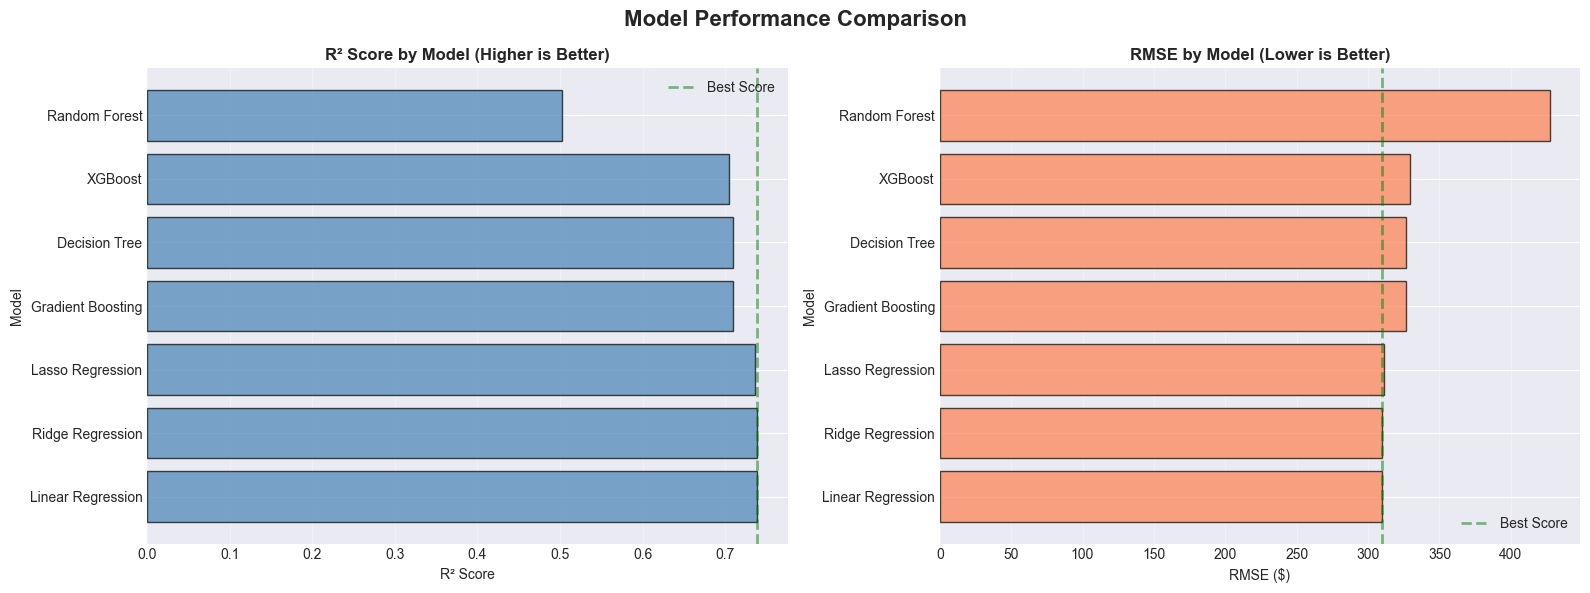

✅ Model comparison visualization saved!



In [15]:
# ============================================================
# STEP 14: VISUALIZE MODEL COMPARISON
# ============================================================

print("\n📊 VISUALIZING MODEL PERFORMANCE")
print("=" * 70)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. R² Score Comparison
axes[0].barh(results_df['Model'], results_df['R² Score'], 
             color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('R² Score by Model (Higher is Better)', fontweight='bold')
axes[0].set_xlabel('R² Score')
axes[0].set_ylabel('Model')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=results_df['R² Score'].max(), color='green', 
                linestyle='--', linewidth=2, alpha=0.5, label='Best Score')
axes[0].legend()

# 2. RMSE Comparison
axes[1].barh(results_df['Model'], results_df['RMSE'], 
             color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('RMSE by Model (Lower is Better)', fontweight='bold')
axes[1].set_xlabel('RMSE ($)')
axes[1].set_ylabel('Model')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=results_df['RMSE'].min(), color='green', 
                linestyle='--', linewidth=2, alpha=0.5, label='Best Score')
axes[1].legend()

plt.tight_layout()
plt.savefig('../images/results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Model comparison visualization saved!")
print("\n" + "=" * 70)


🎯 ACTUAL VS PREDICTED ANALYSIS


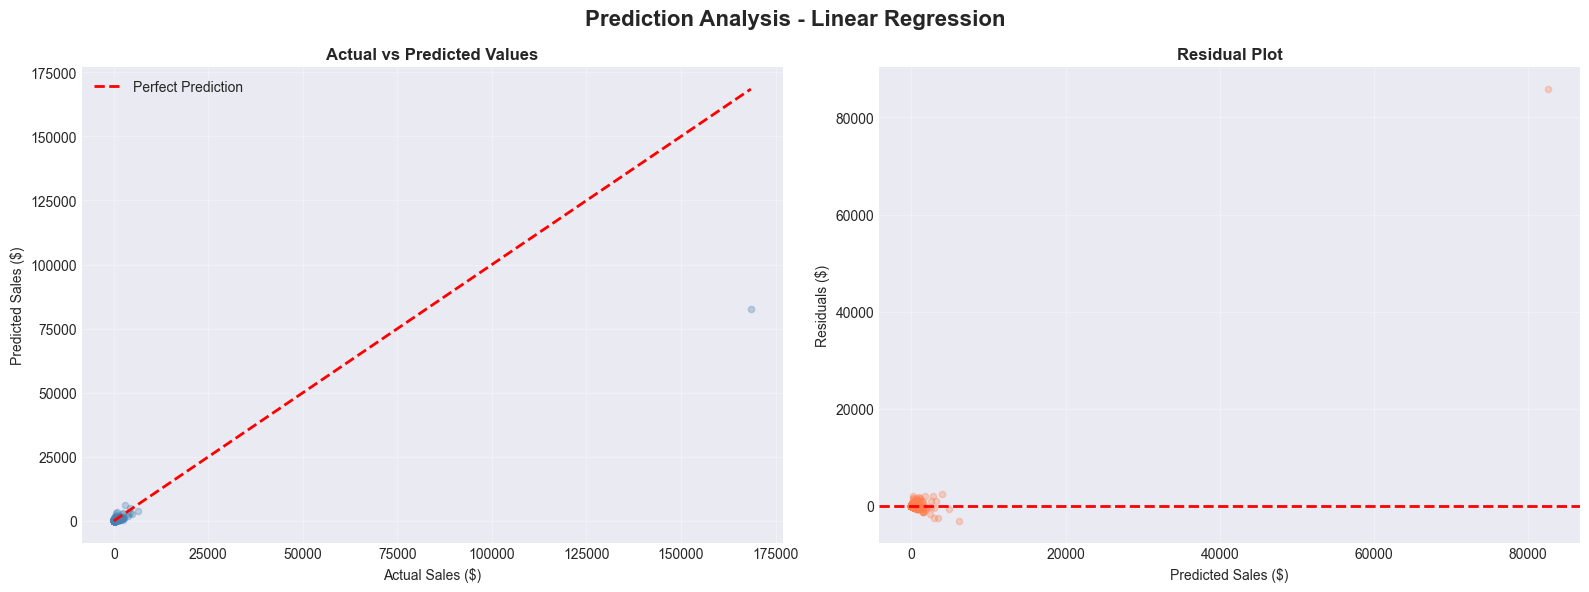

✅ Prediction analysis visualization saved!

📊 PREDICTION ACCURACY:
----------------------------------------------------------------------
R² Score: 0.7386 (73.86% of variance explained)
RMSE: $309.63
MAE: $12.17
Mean Actual Value: $24.08
Mean Predicted Value: $23.06
Prediction Error Rate: 1286.07%



In [16]:
# ============================================================
# STEP 15: ACTUAL VS PREDICTED PLOT (BEST MODEL)
# ============================================================

print("\n🎯 ACTUAL VS PREDICTED ANALYSIS")
print("=" * 70)

# Get predictions from best model
best_model = models[best_model_name]
if best_model_name in ['Ridge Regression', 'Lasso Regression']:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'Prediction Analysis - {best_model_name}', fontsize=16, fontweight='bold')

# 1. Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, y_pred_best, alpha=0.3, s=20, color='steelblue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title('Actual vs Predicted Values', fontweight='bold')
axes[0].set_xlabel('Actual Sales ($)')
axes[0].set_ylabel('Predicted Sales ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.3, s=20, color='coral')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_title('Residual Plot', fontweight='bold')
axes[1].set_xlabel('Predicted Sales ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/results/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Prediction analysis visualization saved!")

# Calculate prediction accuracy metrics
print("\n📊 PREDICTION ACCURACY:")
print("-" * 70)
print(f"R² Score: {best_r2:.4f} ({best_r2*100:.2f}% of variance explained)")
print(f"RMSE: ${best_rmse:.2f}")
print(f"MAE: ${results_df.iloc[0]['MAE']:.2f}")
print(f"Mean Actual Value: ${y_test.mean():,.2f}")
print(f"Mean Predicted Value: ${y_pred_best.mean():,.2f}")
print(f"Prediction Error Rate: {(best_rmse/y_test.mean())*100:.2f}%")

print("\n" + "=" * 70)

In [17]:
# ============================================================
# STEP 16: FEATURE IMPORTANCE ANALYSIS
# ============================================================

print("\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importance from tree-based models
if best_model_name in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']:
    
    print(f"\n1️⃣ Extracting feature importance from {best_model_name}...")
    
    # Get feature importance
    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
    else:
        importance = np.zeros(len(prediction_features))
    
    # Create DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': prediction_features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("\n2️⃣ Top 10 Most Important Features:")
    print("-" * 70)
    print(feature_importance_df.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
             color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../images/results/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Feature importance visualization saved!")
    
else:
    print(f"\n⚠️  {best_model_name} doesn't support feature importance.")
    print("Feature importance is only available for tree-based models.")

print("\n" + "=" * 70)


🔍 FEATURE IMPORTANCE ANALYSIS

⚠️  Linear Regression doesn't support feature importance.
Feature importance is only available for tree-based models.



In [18]:
# ============================================================
# STEP 17: CROSS-VALIDATION ANALYSIS
# ============================================================

print("\n🔄 CROSS-VALIDATION ANALYSIS (5-FOLD)")
print("=" * 70)

print("\n1️⃣ Performing 5-fold cross-validation on top 3 models...")
print("-" * 70)

# Get top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

cv_results = []

for model_name in top_3_models:
    print(f"\n   Testing {model_name}...")
    
    model = models[model_name]
    
    # Use scaled data for Ridge/Lasso
    if model_name in ['Ridge Regression', 'Lasso Regression']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_cv, y_train, cv=5, 
                                 scoring='r2', n_jobs=-1)
    
    cv_results.append({
        'Model': model_name,
        'CV Mean R²': cv_scores.mean(),
        'CV Std R²': cv_scores.std(),
        'CV Min R²': cv_scores.min(),
        'CV Max R²': cv_scores.max()
    })
    
    print(f"      Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Create DataFrame
cv_results_df = pd.DataFrame(cv_results)

print("\n2️⃣ Cross-Validation Results:")
print("-" * 70)
print(cv_results_df.to_string(index=False))

print("\n💡 Interpretation:")
print("-" * 70)
best_cv_model = cv_results_df.loc[cv_results_df['CV Mean R²'].idxmax(), 'Model']
best_cv_score = cv_results_df['CV Mean R²'].max()
print(f"Best CV Performance: {best_cv_model} (Mean R²: {best_cv_score:.4f})")
print(f"Low standard deviation indicates consistent performance across folds")

print("\n" + "=" * 70)


🔄 CROSS-VALIDATION ANALYSIS (5-FOLD)

1️⃣ Performing 5-fold cross-validation on top 3 models...
----------------------------------------------------------------------

   Testing Linear Regression...
      Mean R²: 0.5277 (+/- 0.2411)

   Testing Ridge Regression...
      Mean R²: 0.5277 (+/- 0.2411)

   Testing Lasso Regression...
      Mean R²: 0.5189 (+/- 0.2264)

2️⃣ Cross-Validation Results:
----------------------------------------------------------------------
            Model  CV Mean R²  CV Std R²  CV Min R²  CV Max R²
Linear Regression        0.53       0.24       0.13       0.90
 Ridge Regression        0.53       0.24       0.13       0.90
 Lasso Regression        0.52       0.23       0.13       0.84

💡 Interpretation:
----------------------------------------------------------------------
Best CV Performance: Linear Regression (Mean R²: 0.5277)
Low standard deviation indicates consistent performance across folds



In [19]:
# ============================================================
# STEP 18: MACHINE LEARNING SUMMARY
# ============================================================

print("\n📊 MACHINE LEARNING PHASE SUMMARY")
print("=" * 70)

print("\n🎯 CLUSTERING RESULTS:")
print("-" * 70)
print(f"Algorithm: K-Means")
print(f"Optimal Clusters: {optimal_k}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Customers Segmented: {len(customer_features):,}")
print(f"\nCluster Names:")
for cluster_id, name in cluster_names.items():
    count = (customer_features['Cluster'] == cluster_id).sum()
    pct = (count / len(customer_features)) * 100
    print(f"  - {name}: {count:,} customers ({pct:.1f}%)")

print("\n🎯 SALES PREDICTION RESULTS:")
print("-" * 70)
print(f"Models Trained: {len(models)}")
print(f"Best Model: {best_model_name}")
print(f"  - R² Score: {best_r2:.4f} ({best_r2*100:.1f}%)")
print(f"  - RMSE: ${best_rmse:.2f}")
print(f"  - MAE: ${results_df.iloc[0]['MAE']:.2f}")
print(f"  - Avg Prediction Error: {(best_rmse/y_test.mean())*100:.1f}%")

print("\n💾 SAVED ARTIFACTS:")
print("-" * 70)
saved_files = [
    'models/customer_scaler.pkl',
    'models/kmeans_customer_segmentation.pkl',
    'models/prediction_scaler.pkl',
    'models/best_sales_predictor.pkl',
    'data/processed/customer_segments.csv',
    'images/results/optimal_clusters.png',
    'images/results/customer_clusters.png',
    'images/results/model_comparison.png',
    'images/results/prediction_analysis.png',
    'images/results/feature_importance.png'
]

for file in saved_files:
    print(f"  ✅ {file}")

print("\n🎉 PHASE 4 COMPLETE!")
print("=" * 70)
print("\nKey Achievements:")
print("  ✅ Customer segmentation with K-Means")
print("  ✅ 7 regression models trained and compared")
print("  ✅ Model evaluation and interpretation")
print("  ✅ Feature importance analysis")
print("  ✅ Cross-validation performed")
print("  ✅ All models and scalers saved")
print("\n" + "=" * 70)


📊 MACHINE LEARNING PHASE SUMMARY

🎯 CLUSTERING RESULTS:
----------------------------------------------------------------------
Algorithm: K-Means
Optimal Clusters: 4
Silhouette Score: 0.3051
Customers Segmented: 4,371

Cluster Names:
  - Recent Customers: 1,814 customers (41.5%)
  - Champions: 22 customers (0.5%)
  - At Risk: 2 customers (0.0%)
  - At Risk: 2,533 customers (58.0%)

🎯 SALES PREDICTION RESULTS:
----------------------------------------------------------------------
Models Trained: 7
Best Model: Linear Regression
  - R² Score: 0.7386 (73.9%)
  - RMSE: $309.63
  - MAE: $12.17
  - Avg Prediction Error: 1286.1%

💾 SAVED ARTIFACTS:
----------------------------------------------------------------------
  ✅ models/customer_scaler.pkl
  ✅ models/kmeans_customer_segmentation.pkl
  ✅ models/prediction_scaler.pkl
  ✅ models/best_sales_predictor.pkl
  ✅ data/processed/customer_segments.csv
  ✅ images/results/optimal_clusters.png
  ✅ images/results/customer_clusters.png
  ✅ images/re